In [10]:
import pandas as pd
X_train_feat = pd.read_csv('/kaggle/input/nk-sec/X_train .csv')
X_train_vals_put = pd.read_csv('/kaggle/input/nk-sec/Y_train_put.csv')
X_train_vals_call = pd.read_csv('/kaggle/input/nk-sec/Y_train_call.csv')

In [11]:
X_test_full = pd.read_csv('/kaggle/input/gogogo/X_test_full.csv').iloc[:, 1:]

In [13]:
cols_to_include_put = ['underlying', 'put_iv_23000',
       'put_iv_23100', 'put_iv_23200', 'put_iv_23300', 'put_iv_23400',
       'put_iv_23500', 'put_iv_23600', 'put_iv_23700', 'put_iv_23800',
       'put_iv_23900', 'put_iv_24000', 'put_iv_24100', 'put_iv_24200',
       'put_iv_24300', 'put_iv_24400', 'put_iv_24500', 'put_iv_24600',
       'put_iv_24700', 'put_iv_24800', 'put_iv_24900', 'put_iv_25000',
       'put_iv_25100', 'put_iv_25200', 'put_iv_25300', 'put_iv_25400',
       'put_iv_25500', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8',
       'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18',
       'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28',
       'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38',
       'X39', 'X40', 'X41']

cols_to_include_call = ['underlying', 'call_iv_24000', 'call_iv_24100', 'call_iv_24200',
       'call_iv_24300', 'call_iv_24400', 'call_iv_24500', 'call_iv_24600',
       'call_iv_24700', 'call_iv_24800', 'call_iv_24900', 'call_iv_25000',
       'call_iv_25100', 'call_iv_25200', 'call_iv_25300', 'call_iv_25400',
       'call_iv_25500', 'call_iv_25600', 'call_iv_25700', 'call_iv_25800',
       'call_iv_25900', 'call_iv_26000', 'call_iv_26100', 'call_iv_26200',
       'call_iv_26300', 'call_iv_26400', 'call_iv_26500', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8',
       'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18',
       'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28',
       'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38',
       'X39', 'X40', 'X41']

In [14]:
X_test_put = X_test_full[cols_to_include_put]
X_test_call = X_test_full[cols_to_include_call]

X_train_put = pd.concat([X_train_feat, X_train_vals_call], axis=1)
X_train_call = pd.concat([X_train_feat, X_train_vals_put], axis=1)

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

class StableIVAutoEncoder:
    def __init__(self):
        self.iv_scaler = MinMaxScaler(feature_range=(0.001, 0.75))
        self.feature_scaler = StandardScaler()
        self.model = None
        self.iv_cols = None
        
    def prepare_data(self, df, is_training=True):
        # Identify columns
        self.iv_cols = [col for col in df.columns if 'iv_' in col.lower()]
        feature_cols = [col for col in df.columns if col not in self.iv_cols]
        
        iv_data = df[self.iv_cols].values.astype(np.float32)
        feature_data = df[feature_cols].values.astype(np.float32)
        
        # Valid mask
        iv_mask = ~np.isnan(iv_data) & (iv_data > 0.001) & (iv_data < 0.75)
        
        if is_training:
            # Fit scalers
            valid_iv_data = iv_data[iv_mask]
            if len(valid_iv_data) > 0:
                valid_iv_data = np.clip(valid_iv_data, 0.001, 0.75)
                self.iv_scaler.fit(valid_iv_data.reshape(-1, 1))
            self.feature_scaler.fit(feature_data)
        
        # Simple filling for training
        iv_data_filled = self.simple_fill_missing(iv_data, iv_mask, feature_data)
        
        # Scale
        iv_data_scaled = self.iv_scaler.transform(iv_data_filled.reshape(-1, 1)).reshape(iv_data_filled.shape)
        feature_data_scaled = self.feature_scaler.transform(feature_data)
        
        return iv_data_scaled, feature_data_scaled, iv_mask, iv_data_filled
    
    def simple_fill_missing(self, iv_data, iv_mask, feature_data):
        """Simple, stable filling"""
        iv_data_filled = iv_data.copy()
        
        for i in range(len(iv_data)):
            row_mask = iv_mask[i]
            
            # If row has valid values, use row median
            if row_mask.sum() > 0:
                row_median = np.median(iv_data[i][row_mask])
                iv_data_filled[i][~row_mask] = row_median
            else:
                # Use global default
                iv_data_filled[i][~row_mask] = 0.2
        
        return np.clip(iv_data_filled, 0.001, 0.75)
    
    def build_model(self, iv_dim, feature_dim):
        # Simple, stable architecture
        iv_input = layers.Input(shape=(iv_dim,), name='iv_input')
        feature_input = layers.Input(shape=(feature_dim,), name='feature_input')
        
        # IV encoder
        iv_encoded = layers.Dense(64, activation='relu')(iv_input)
        iv_encoded = layers.BatchNormalization()(iv_encoded)
        iv_encoded = layers.Dropout(0.1)(iv_encoded)
        
        iv_encoded = layers.Dense(32, activation='relu')(iv_encoded)
        
        # Feature encoder  
        feat_encoded = layers.Dense(32, activation='relu')(feature_input)
        feat_encoded = layers.BatchNormalization()(feat_encoded)
        feat_encoded = layers.Dropout(0.1)(feat_encoded)
        
        feat_encoded = layers.Dense(16, activation='relu')(feat_encoded)
        
        # Combine
        combined = layers.concatenate([iv_encoded, feat_encoded])
        combined = layers.Dense(48, activation='relu')(combined)
        combined = layers.Dropout(0.1)(combined)
        
        # Output
        output = layers.Dense(iv_dim, activation='sigmoid')(combined)
        
        model = keras.Model(inputs=[iv_input, feature_input], outputs=output)
        return model
    
    def train(self, X_train, epochs=150, batch_size=512):
        print("Preparing training data...")
        iv_train, feat_train, _, _ = self.prepare_data(X_train, is_training=True)
        
        print(f"Training shapes: IV {iv_train.shape}, Features {feat_train.shape}")
        
        # Build model
        self.model = self.build_model(iv_train.shape[1], feat_train.shape[1])
        
        # Simple MSE loss
        def stable_loss(y_true, y_pred):
            return tf.reduce_mean(tf.square(y_true - y_pred))
        
        # Conservative training
        optimizer = keras.optimizers.Adam(learning_rate=0.0005)
        self.model.compile(optimizer=optimizer, loss=stable_loss, metrics=['mae'])
        
        callbacks = [
            keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=8, min_lr=1e-6)
        ]
        
        print("Training...")
        history = self.model.fit(
            [iv_train, feat_train], iv_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        return history
    
    def predict_with_anchoring(self, X_test):
        """The key: anchor predictions to known test values"""
        print("Making anchored predictions...")
        
        # Step 1: Get raw model predictions (ignoring test NaNs for now)
        iv_test, feat_test, _, _ = self.prepare_data(X_test, is_training=False)
        raw_predictions = self.model.predict([iv_test, feat_test], batch_size=1024)
        
        # Convert to original scale
        raw_predictions = raw_predictions * (0.75 - 0.001) + 0.001
        raw_predictions = np.clip(raw_predictions, 0.001, 0.75)
        
        # Step 2: Get original test data
        original_test = X_test[self.iv_cols].values
        known_mask = ~np.isnan(original_test) & (original_test > 0.001) & (original_test < 0.75)
        
        # Step 3: ANCHOR - Simply replace predictions with known values
        anchored_predictions = raw_predictions.copy()
        anchored_predictions[known_mask] = original_test[known_mask]
        
        # Step 4: For missing values, smooth using neighbors
        final_predictions = self.smooth_missing_values(anchored_predictions, known_mask, X_test)
        
        print(f"Prediction range: {final_predictions.min():.4f} to {final_predictions.max():.4f}")
        print(f"Anchored {known_mask.sum()} known values")
        
        # Create result
        result = X_test.copy()
        for i, col in enumerate(self.iv_cols):
            result[col] = final_predictions[:, i]
        
        return result
    
    def smooth_missing_values(self, predictions, known_mask, X_test):
        """Smooth only the missing values using neighboring known values"""
        smoothed = predictions.copy()
        
        # Extract strikes
        strikes = []
        for col in self.iv_cols:
            try:
                strike = float(col.split('_')[-1])
                strikes.append(strike)
            except:
                strikes.append(0)
        strikes = np.array(strikes)
        
        # Process each row
        for i in range(len(predictions)):
            row_known = known_mask[i]
            
            if row_known.sum() > 1:  # Need at least 2 known points
                # For unknown values, interpolate from nearest known values
                for j in range(len(strikes)):
                    if not row_known[j]:  # This is an unknown value
                        # Find nearest known values
                        known_indices = np.where(row_known)[0]
                        distances = np.abs(strikes[known_indices] - strikes[j])
                        
                        if len(distances) >= 2:
                            # Use 2 nearest known points for linear interpolation
                            nearest_2 = np.argsort(distances)[:2]
                            idx1, idx2 = known_indices[nearest_2[0]], known_indices[nearest_2[1]]
                            
                            # Linear interpolation
                            x1, x2 = strikes[idx1], strikes[idx2]
                            y1, y2 = predictions[i, idx1], predictions[i, idx2]
                            x = strikes[j]
                            
                            # Interpolate
                            if x2 != x1:
                                interpolated = y1 + (y2 - y1) * (x - x1) / (x2 - x1)
                                smoothed[i, j] = np.clip(interpolated, 0.001, 0.75)
        
        return smoothed

def final_curve_smoothing(df, option_type='call'):
    """Final light smoothing to ensure beautiful curves"""
    iv_cols = [col for col in df.columns if f'{option_type}_iv_' in col]
    
    if len(iv_cols) < 3:
        return df
    
    result_df = df.copy()
    
    # Simple 3-point moving average for smoothness
    for idx in range(len(df)):
        iv_values = np.array([df.iloc[idx][col] for col in iv_cols])
        
        # Light smoothing
        smoothed = iv_values.copy()
        for i in range(1, len(iv_values) - 1):
            smoothed[i] = 0.25 * iv_values[i-1] + 0.5 * iv_values[i] + 0.25 * iv_values[i+1]
        
        # Update
        for i, col in enumerate(iv_cols):
            result_df.iloc[idx, result_df.columns.get_loc(col)] = np.clip(smoothed[i], 0.001, 0.75)
    
    return result_df

def train_and_predict_stable_iv(X_train_put, X_test_put, X_train_call=None, X_test_call=None):
    """Stable, no-nonsense approach (PUT as primary)"""
    results = {}

    print("=" * 50)
    print("STABLE IV AUTOENCODER - ANCHORED PREDICTIONS")
    print("=" * 50)

    # PUT options (Primary)
    print("\nProcessing PUT options (primary)...")
    autoencoder_put = StableIVAutoEncoder()
    autoencoder_put.train(X_train_put, epochs=120, batch_size=512)

    put_predictions = autoencoder_put.predict_with_anchoring(X_test_put)
    put_predictions = final_curve_smoothing(put_predictions, 'put')

    results['put'] = put_predictions

    # CALL options (Optional)
    if X_train_call is not None and X_test_call is not None:
        print("\nProcessing CALL options (secondary)...")
        autoencoder_call = StableIVAutoEncoder()
        autoencoder_call.train(X_train_call, epochs=120, batch_size=512)

        call_predictions = autoencoder_call.predict_with_anchoring(X_test_call)
        call_predictions = final_curve_smoothing(call_predictions, 'call')

        results['call'] = call_predictions

    return results

# Usage
if __name__ == "__main__":
    results = train_and_predict_stable_iv(X_train_put, X_test_put, X_train_call, X_test_call)

    print("\n" + "=" * 50)
    print("STABLE ANCHORED IV AUTOENCODER COMPLETE!")
    print("=" * 50)
    print("Strategy:")
    print("1. Train autoencoder on smile patterns (PUT)")
    print("2. Make raw predictions")  
    print("3. ANCHOR: Replace with known test values")
    print("4. Interpolate missing values from neighbors")
    print("5. Light smoothing for beautiful curves")
    print("\nNo more chaos! 🎯")

STABLE IV AUTOENCODER - ANCHORED PREDICTIONS

Processing PUT options (primary)...
Preparing training data...
Training shapes: IV (138577, 26), Features (138577, 43)
Training...
Epoch 1/120
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0490 - mae: 0.1736 - val_loss: 0.0117 - val_mae: 0.0919 - learning_rate: 5.0000e-04
Epoch 2/120
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037 - mae: 0.0473 - val_loss: 0.0042 - val_mae: 0.0547 - learning_rate: 5.0000e-04
Epoch 3/120
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - mae: 0.0354 - val_loss: 0.0030 - val_mae: 0.0434 - learning_rate: 5.0000e-04
Epoch 4/120
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mae: 0.0295 - val_loss: 0.0028 - val_mae: 0.0427 - learning_rate: 5.0000e-04
Epoch 5/120
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0021 - val_mae: 0.0347 - learning_rate: 5.0000e-04
Epoch 6/120
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.8057e-04 - mae: 0.0241 

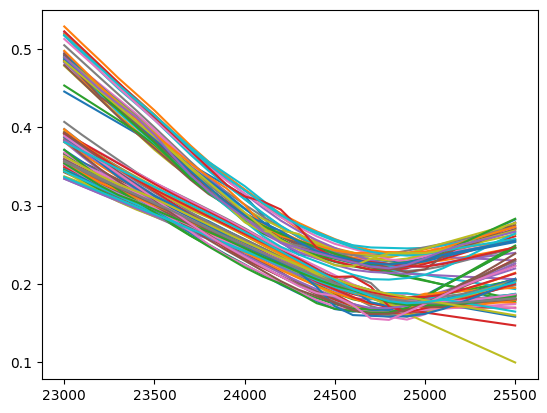

In [16]:
import matplotlib.pyplot as plt
for i in range(100):
    plt.plot([int(col.split('_')[-1]) for col in results['put'].iloc[:, 1:27].columns], results['put'].iloc[:, 1:27].iloc[i])

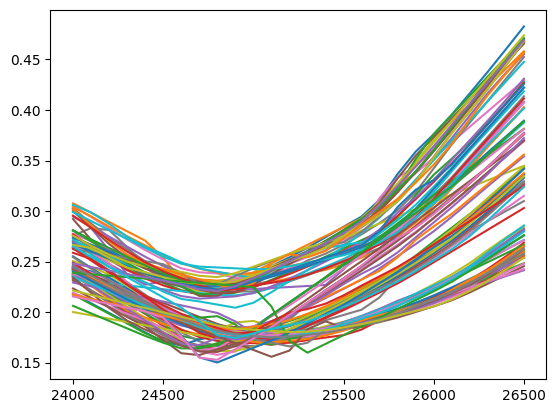

In [17]:
import matplotlib.pyplot as plt
for i in range(100):
    plt.plot([int(col.split('_')[-1]) for col in results['call'].iloc[:, 1:27].columns], results['call'].iloc[:, 1:27].iloc[i])